In [1]:
import tensorflow as tf
import tensorflow_datasets as tf_ds

In [9]:
(x_train,_),(x_test,_)=tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [95]:
data=tf.concat([x_train,x_test],axis=0)

In [24]:
a=tf.constant([[1,2,1],[1,2,1]])
b=tf.constant([[2,2,2],[2,2,2]])

In [25]:
a

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 1],
       [1, 2, 1]], dtype=int32)>

In [26]:
b

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 2, 2],
       [2, 2, 2]], dtype=int32)>

In [27]:
tf.concat([a,b],axis=-1)

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 2, 1, 2, 2, 2],
       [1, 2, 1, 2, 2, 2]], dtype=int32)>

In [96]:
data=tf.expand_dims(data,axis=-1)
data=tf.cast(data,dtype=tf.float32)
data=data/255.

In [97]:
data.shape

TensorShape([70000, 28, 28, 1])

In [98]:
data=tf.data.Dataset.from_tensor_slices(data)

In [99]:
data=data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [100]:
len(data)

2188

In [63]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Input,Reshape,Conv2DTranspose

In [109]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inp):
    mean,log_var=inp
    # print(inp[0].shape[0])
    s=inp[0].shape[0]
    in_shap= s if s else 32
    return mean+tf.math.exp(0.5*log_var)*tf.random.normal(shape=[in_shap,LATEN_INP])

In [110]:
LATEN_INP=2
encod_inp=Input(shape=(28,28,1))
x=Conv2D(32,3,strides=2,activation="relu",padding="same")(encod_inp)
x=Conv2D(64,3,strides=2,activation="relu",padding="same")(x)
x=Flatten()(x)
x=Dense(16,activation="relu")(x)
mean=Dense(LATEN_INP)(x)
log_var=Dense(LATEN_INP)(x)
z=Sampling()([mean,log_var])
en_model=tf.keras.models.Model(encod_inp,[z,mean,log_var])

In [111]:
# en_model(tf.random.normal((32,28,28,1)))

In [112]:
en_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 14, 14, 32)   320         ['input_27[0][0]']               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_29[0][0]']              
                                                                                                  
 flatten_14 (Flatten)           (None, 3136)         0           ['conv2d_30[0][0]']              
                                                                                            

In [113]:
decode_in=Input(shape=(LATEN_INP,))
x=Dense(7*7*64,activation="relu")(decode_in)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(32,3,strides=2,activation="relu",padding="same")(x)
x=Conv2DTranspose(32,3,strides=2,activation="relu",padding="same")(x)
decode_out=Conv2DTranspose(1,3,activation="sigmoid",padding="same")(x)
decode_model=tf.keras.models.Model(decode_in,decode_out)

In [114]:
decode_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_49 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 14, 14, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 28, 28, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 28, 28, 1)        289 

In [115]:
# en_model(tf.random.normal((1, 28, 28, 1)))

In [118]:
# def custom_loss()

In [119]:
vae_inp=Input((28,28,1))
z,_,_=en_model(vae_inp)
decode_out=decode_model(z)
vae_model=tf.keras.models.Model(vae_inp,decode_out)

In [120]:
vae_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 model_5 (Functional)        [(32, 2),                 69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 model_6 (Functional)        (None, 28, 28, 1)         37409     
                                                                 
Total params: 106,485
Trainable params: 106,485
Non-trainable params: 0
_________________________________________________________________


In [121]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [122]:
optimi=tf.keras.optimizers.Adam(learning_rate=1e-3)

In [123]:
def train_step(x_batches):
  with tf.GradientTape() as recorder:
    z,mean,log_var=en_model(x_batches)
    y_pre=decode_model(z)
    y_tru=x_batches
    loss=custom_loss(y_tru,y_pre,mean,log_var)
  partial_derivatives=recorder.gradient(loss,vae_model.trainable_weights)
  optimi.apply_gradients(zip(partial_derivatives,vae_model.trainable_weights))
  return loss


In [124]:
# train_step(tf.random.normal((32,28,28,1)))

In [127]:
def fit(epochs):
  loss_dict={}
  print("==== Training start ====")
  for epoch in range(1,epochs+1):
    print(f"current epoch is {epoch}")
    for step,x_batch in enumerate(data):
      loss=train_step(x_batch)
    print(f"after complete {epoch} epoch loss is {loss}")
    loss_dict.update({epoch:loss})
  print("Training Done")
  return loss

In [ ]:
fit(10)

In [141]:
out=vae_model.layers[2](tf.constant([[1,2],[2,1],[0.1,0.2]]))

In [142]:
out.shape

TensorShape([3, 28, 28, 1])

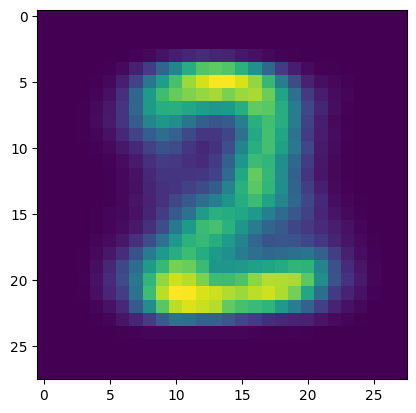

In [143]:
import matplotlib.pyplot as plt
plt.imshow(out[2])

In [148]:
## to plot the mean and var
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()


In [149]:
_,mean,var=vae_model.layers[1](x_test)

(60000, 2)

1875/1875 [==============================] - 4s 2ms/step


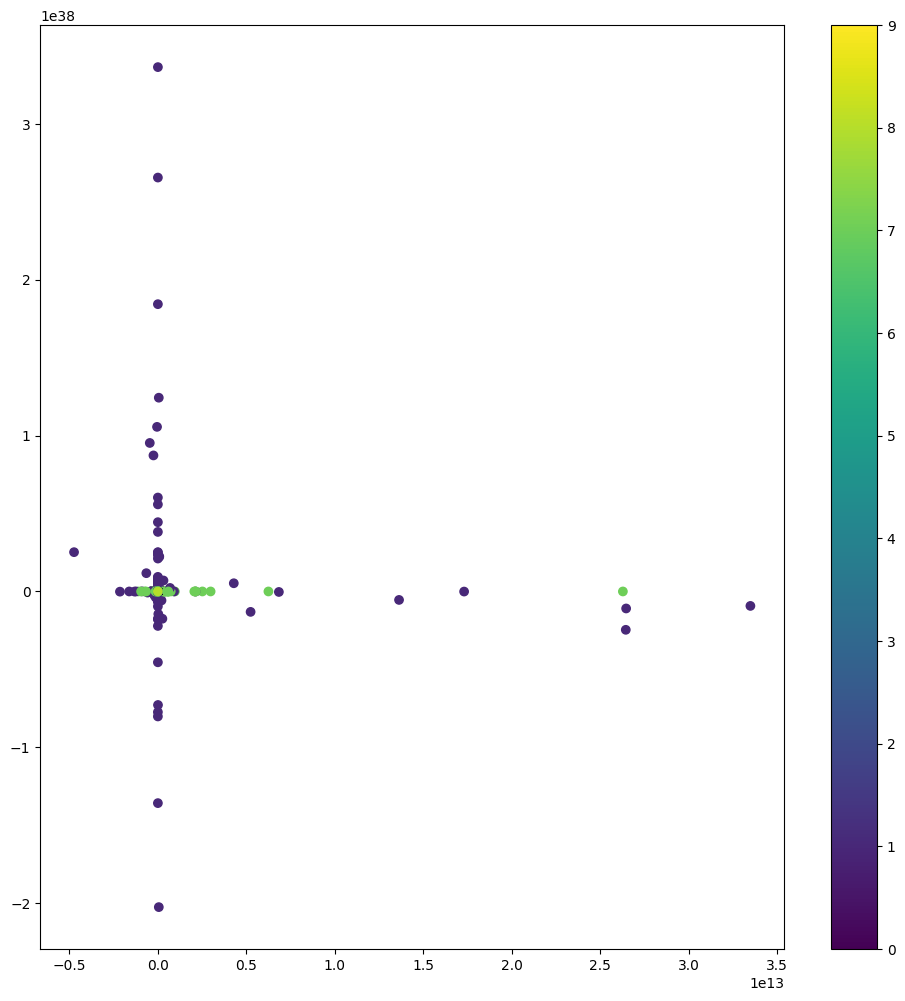

In [156]:
z,_,_=vae_model.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()